# Pump It Up Challenge: Driven Data

## Modules importing

In [1]:
import pandas as pd
import numpy as np
import phik
import multiprocessing as mp
import shap

import lightgbm as lgb

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, _fit_transform_one, _transform_one

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

from scipy import sparse
from tqdm import tqdm
from joblib import Parallel, delayed

from pathlib import Path
from functools import partial
from typing import List, Dict, Tuple, Union, Optional

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Settings

In [5]:
PATH2PROJECT = Path('..')
PATH2CONFIGS = PATH2PROJECT / 'config'
PATH2DATA = PATH2PROJECT / 'data'
PATH2OUTPUT = PATH2PROJECT / 'output'

In [6]:
ID = 'id'
TARGET = 'status_group'
DATE = 'date_recorded'

In [7]:
SEED = 42
METRIC = 'auc_mu'

## Data Loading

In [8]:
df_test = pd.read_csv(PATH2DATA / 'Test_set_values.csv')
df_test.shape

(14850, 40)

In [9]:
df_train = pd.read_csv(PATH2DATA / 'training_Set_values.csv')
df_train.shape

(59400, 40)

In [10]:
y_train = pd.read_csv(PATH2DATA / 'training_Set_labels.csv')
y_train.shape

(59400, 2)

In [11]:
assert len(y_train.status_group.unique()) == 3

In [12]:
assert df_train.shape[0] == y_train.shape[0]

In [13]:
df_train = df_train.merge(y_train, on=ID, how='inner')
df_train.shape

(59400, 41)

In [14]:
assert df_train.shape[0] == y_train.shape[0]

## Simple EDA

In [15]:
numerical_columns = df_train.drop(columns=[ID, TARGET, 'region_code', 'district_code']).select_dtypes(include=['float', 'int']).columns.tolist()
categorical_columns = df_train.drop(columns=[ID, TARGET]).select_dtypes(include='object').columns.tolist() + ['region_code', 'district_code']

### Target

In [16]:
assert all(df_train.groupby(ID)[TARGET].count() == 1)

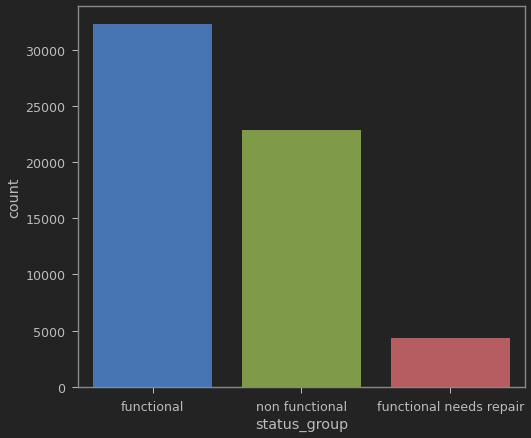

In [17]:
sns.countplot(x=df_train[TARGET]);

In [18]:
df_train[TARGET].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [19]:
print('min id=%d; max id=%d' % (df_train[ID].min(), df_train[ID].max()))

min id=0; max id=74247


### Train data

In [20]:
df_train.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [21]:
df_train[numerical_columns].describe()

amount_tsh    gps_height     longitude      latitude   num_private  \
count   59400.000000  59400.000000  59400.000000  5.940000e+04  59400.000000   
mean      317.650385    668.297239     34.077427 -5.706033e+00      0.474141   
std      2997.574558    693.116350      6.567432  2.946019e+00     12.236230   
min         0.000000    -90.000000      0.000000 -1.164944e+01      0.000000   
25%         0.000000      0.000000     33.090347 -8.540621e+00      0.000000   
50%         0.000000    369.000000     34.908743 -5.021597e+00      0.000000   
75%        20.000000   1319.250000     37.178387 -3.326156e+00      0.000000   
max    350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000   

         population  construction_year  
count  59400.000000       59400.000000  
mean     179.909983        1300.652475  
std      471.482176         951.620547  
min        0.000000           0.000000  
25%        0.000000           0.000000  
50%       25.000000        1986.000000  
75%      215.000000        2004.000000  
max    30500.000000        2013.000000

In [22]:
def simple_na_report(df: pd.DataFrame) -> pd.core.series.Series:
    t = df_train.isnull().sum() / len(df_train)
    return t[t > 0]

simple_na_report(df_train)

funder               0.061195
installer            0.061532
subvillage           0.006246
public_meeting       0.056128
scheme_management    0.065269
scheme_name          0.474175
permit               0.051448
dtype: float64

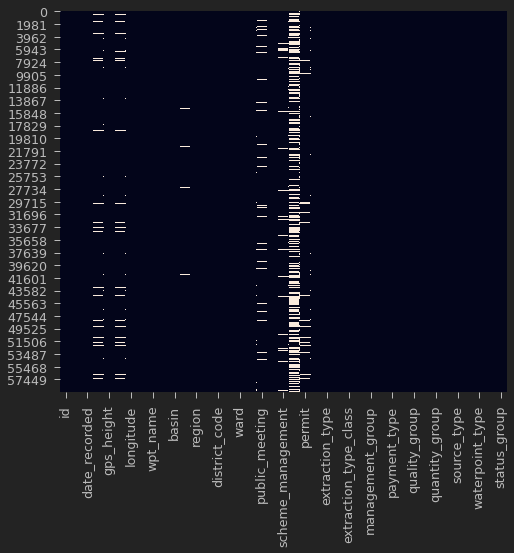

In [23]:
sns.heatmap(df_train.isnull(), cbar=False);

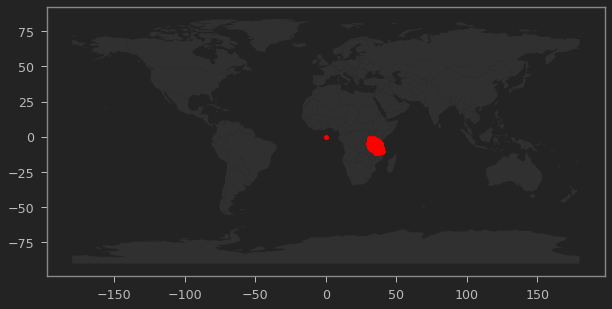

In [24]:
geometry = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]
gdf = GeoDataFrame(geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=10);

In [25]:
for col in categorical_columns:
    if len(df_train[col].unique()) > 25:
        continue
    temp = df_train.groupby([col, TARGET]).count()[ID].reset_index()
    fig = px.bar(temp, x=col, y=ID, color=TARGET, title=f"{col} - count of id`s",width=1000, height=500)
    fig.show()
del temp

In [26]:
print('Columns with high cardinality:')
high_cardinality_columns = []
for col in categorical_columns:
    unique_cnt = len(df_train[col].unique())
    if unique_cnt > 25:
        high_cardinality_columns.append(col)
        print(f'- {col}: {unique_cnt} unique values')

Columns with high cardinality:
- date_recorded: 356 unique values
- funder: 1898 unique values
- installer: 2146 unique values
- wpt_name: 37400 unique values
- subvillage: 19288 unique values
- lga: 125 unique values
- ward: 2092 unique values
- scheme_name: 2697 unique values
- region_code: 27 unique values


In [27]:
print('Columns which contain minor categories:')
minor_cat_columns = []
for col in categorical_columns:
    minor_cnt = len([*filter(lambda x: x < 5e-2, df_train[col].value_counts(normalize=True).values)])
    if minor_cnt > 0:
        minor_cat_columns.append(col)
        print(f'- {col}: {minor_cnt} minor categories')

Columns which contain minor categories:
- date_recorded: 356 minor categories
- funder: 1895 minor categories
- installer: 2144 minor categories
- wpt_name: 37399 minor categories
- basin: 1 minor categories
- subvillage: 19287 minor categories
- region: 13 minor categories
- lga: 125 minor categories
- ward: 2092 minor categories
- scheme_management: 8 minor categories
- scheme_name: 2696 minor categories
- extraction_type: 13 minor categories
- extraction_type_group: 8 minor categories
- extraction_type_class: 2 minor categories
- management: 10 minor categories
- management_group: 3 minor categories
- payment: 1 minor categories
- payment_type: 1 minor categories
- water_quality: 6 minor categories
- quality_group: 4 minor categories
- quantity: 1 minor categories
- quantity_group: 1 minor categories
- source: 6 minor categories
- source_type: 3 minor categories
- source_class: 1 minor categories
- waterpoint_type: 3 minor categories
- waterpoint_type_group: 3 minor categories
- reg

## Feature Engineering

In [263]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names: List[str]):
        self.feature_names = feature_names 
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return X[self.feature_names]

In [264]:
class FeatureDrop(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names: List[str]):
        self.feature_names = feature_names 
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return X.drop(columns=self.feature_names)

In [265]:
class ToDateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names):
        self._feature_names = feature_names
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_temp = X.copy()
        for feature in self._feature_names:
            X_temp.loc[:, feature] =  pd.to_datetime(X_temp[feature])
        return X_temp

In [266]:
class NumericalFeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_temp = X.copy()
        X_temp['date_recorded_quarter_dt'] = X_temp['date_recorded'].dt.quarter
        X_temp['date_recorded_month_dt'] = X_temp['date_recorded'].dt.month
        X_temp['date_recorded_year_dt'] = X_temp['date_recorded'].dt.year

        X_temp['date_recorded_quarter_dt_sin'] = X_temp['date_recorded_quarter_dt'].apply(lambda X_temp: np.sin(2 * np.pi * X_temp / 3))
        X_temp['date_recorded_quarter_dt_cos'] = X_temp['date_recorded_quarter_dt'].apply(lambda X_temp: np.cos(np.pi * X_temp / 3))
        X_temp['date_recorded_month_dt_sin'] = X_temp['date_recorded_quarter_dt'].apply(lambda X_temp: np.sin(np.pi * X_temp / 11))
        X_temp['date_recorded_month_dt_cos'] = X_temp['date_recorded_quarter_dt'].apply(lambda X_temp: np.cos(np.pi * X_temp / 11))

        X_temp['date_recorded_year_dt_sub_construction_year'] = X_temp['date_recorded_year_dt'] - X_temp['construction_year']
        X_temp['date_recorded_year_dt_sub_construction_year_div_population'] = (X_temp['date_recorded_year_dt'] - X_temp['construction_year']) / X_temp['population']

        X_temp['amount_tsh_div_population'] = X_temp['amount_tsh'] / X_temp['population']
        
        return X_temp.replace([np.inf, -np.inf], np.nan)

In [267]:
class CategoricalFeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_temp = X.copy()
        X_temp['quality_group'].replace({'salty':'not_good','unknown':'not_good','milky':'not_good','colored':'not_good',
                              'fluoride':'not_good'},inplace=True)
        X_temp['scheme_management'].replace({'SWC':'VWC','Water authority':'government','Water Board':'government','Parastatal':'government'
                                           ,'Private operator':'private','Company':'private','Other':'private','Trust':'board','WUG':'board',
                                            'WUA':'board'
                                           },inplace=True)
        
        X_temp['funder']=X_temp['funder'].astype('str')
        X_temp['installer']=X_temp['installer'].astype('str')

        X_temp['funder']=X_temp['funder'].apply(lambda x:x.lower())
        X_temp['installer']=X_temp['installer'].apply(lambda x:x.lower())

        X_temp['funder'].replace({'0':'none'},inplace=True)
        X_temp['funder'].fillna('none',inplace=True)

        X_temp['installer'].replace({'0':'none'},inplace=True)
        X_temp['installer'].fillna('none',inplace=True)

        X_temp['quality_quantity']=(X_temp['quality_group'].astype(str)
                           +"_"+
                           X_temp['quantity'].astype(str)
                          )
        
        X_temp['installer'] = X_temp['installer'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                                        'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                                        'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                                        'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                                        'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                                        'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                                        'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                                    ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                                     'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                                      'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                                    'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                    'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                                    'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                                      'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                                      'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                                   'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                                       'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                                'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                                  'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                                  'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe','mosque bugula':'mosque','mosque pera':'mosque','water of water':'water',
                                      'romam catholc/vil':'church'})
        
        X_temp['funder'] = X_temp['funder'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                         'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                          'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                           'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                    'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                    'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                       'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                        ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                         'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                          'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                            'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                            'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                              'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                              'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                               'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                               'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                            'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                              'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                              'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe','mosque bugula':'mosque','mosque pera':'mosque','water of water':'water',
                                      'romam catholc/vil':'church'})

        return X_temp

In [268]:
class CategoricalLabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, in_features: Optional[List] = None,):  
        self.in_features = in_features
        self.encoders = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        if self.in_features is None:
            self.in_features = X.columns.tolist()

        self.encoders = {col: LabelEncoder() for col in self.in_features}
            
        for col in self.in_features:
            self.encoders[col].fit(X[col].astype(str))

        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_test = X.copy()
        for col in self.in_features:
            X_test[f'{col}_label_encoding'.replace(' ', '_')] = self.encoders[col].transform(X_test[col].astype(str))
        return X_test
    
    def __repr__(self):
        return f'{self.__class__.__name__} encode {len(self.in_features)} features.'

In [269]:
class CategoricalKFoldMeanEncoding(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        weight: float = 10,
        n_splits: int = 5,
        shuffle: bool = False,
        random_state: int = 42,
        use_kflod_strategy: bool = True,
        in_features: Optional[List] = None,
    ):  
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
#         self.kfold = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state if self.shuffle else None,)
        self.kfold = StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state if self.shuffle else None,)
        self.in_features = in_features
        self.splits = []
        self.y_unique = []
        self.fold_encoder = dict()
        self.test_encoder = dict()
        self.weight = weight
        self.use_kflod_strategy = use_kflod_strategy

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        # train encoder by fold
        self.idx = X.index.copy()
        X_temp = X.reset_index(drop=True).copy()
        
        if self.in_features is None:
            self.in_features = X_temp.columns.tolist()
        self.y_unique = y.unique()
        self.splits = list(self.kfold.split(X_temp, y))
        
        for fold_id, (train_index, _) in enumerate(self.splits):
            self.fold_encoder[fold_id] = {}
            X_train = X_temp.loc[train_index, self.in_features].copy()
            for target_value in self.y_unique:
                X_train['target_col'] = (y == target_value).astype(int)
                global_mean = X_train['target_col'].mean()
                self.fold_encoder[fold_id][target_value] = {}
                for feature in self.in_features:
                    statistics = X_train.groupby(feature)['target_col'].agg(['count', 'mean'])
                    smooth_mean = ((statistics['count'] * statistics['mean'] + self.weight * global_mean) / (
                                statistics['count'] + self.weight)).to_dict()
                    self.fold_encoder[fold_id][target_value][feature] = smooth_mean

        # train encoder using all records
        X_train = X.copy()
        for target_value in self.y_unique:
            X_train['target_col'] = (y == target_value).astype(int)
            global_mean = X_train['target_col'].mean()
            self.test_encoder[target_value] = {}
            for feature in self.in_features:
                statistics = X_train.groupby(feature)['target_col'].agg(['count', 'mean'])

                smooth_mean = ((statistics['count'] * statistics['mean'] + self.weight * global_mean) / (
                            statistics['count'] + self.weight)).to_dict()
                self.test_encoder[target_value][feature] = smooth_mean

        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        if self.use_kflod_strategy:
            encoded = []
            X_temp = X.reset_index(drop=True).copy()
            for fold_id, (_, test_index) in enumerate(self.splits):
                X_test = X_temp.loc[test_index, self.in_features].copy()
                for feature in self.in_features:
                    if len(self.y_unique) <= 2:
                        target_value = self.y_unique[0]
                        X_test[f'{feature}_{target_value}_target_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
                    else:
                        for target_value in self.y_unique:
                            X_test[f'{feature}_{target_value}_target_encoding'.replace(' ', '_')] = X_test[feature].map(self.fold_encoder[fold_id][target_value][feature])
                encoded.append(X_test.set_index(test_index))
            X_test = pd.concat(encoded).sort_index().set_index(self.idx)
        else:
            X_test = X.copy()
            for feature in self.in_features:
                if len(self.y_unique) <= 2:
                    target_value = self.y_unique[0]
                    X_test[f'{feature}_{target_value}_target_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
                else:
                    for target_value in self.y_unique:
                        X_test[f'{feature}_{target_value}_target_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
        return X_test
    
    def __repr__(self):
        return f'{self.__class__.__name__} encode {len(self.in_features)} features.'

In [270]:
class CategoricalKFoldVarEncoding(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        n_splits: int = 5,
        shuffle: bool = False,
        random_state: int = 42,
        use_kflod_strategy: bool = True,
        in_features: Optional[List] = None,
    ):  
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
#         self.kfold = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state if self.shuffle else None,)
        self.kfold = StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state if self.shuffle else None,)
        self.in_features = in_features
        self.splits = []
        self.y_unique = []
        self.fold_encoder = dict()
        self.test_encoder = dict()
        self.use_kflod_strategy = use_kflod_strategy
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        # train encoder by fold
        self.idx = X.index.copy()
        X_temp = X.reset_index(drop=True).copy()
        
        if self.in_features is None:
            self.in_features = X_temp.columns.tolist()
        self.y_unique = y.unique()
        self.splits = list(self.kfold.split(X_temp, y))
        
        for fold_id, (train_index, _) in enumerate(self.splits):
            self.fold_encoder[fold_id] = {}
            X_train = X_temp.loc[train_index, self.in_features].copy()
            for target_value in self.y_unique:
                X_train['target_col'] = (y == target_value).astype(int)
                global_mean = X_train['target_col'].mean()
                self.fold_encoder[fold_id][target_value] = {}
                for feature in self.in_features:
                    self.fold_encoder[fold_id][target_value][feature] = X_train.groupby(feature)['target_col'].var().to_dict()

        # train encoder using all records
        X_train = X.copy()
        for target_value in self.y_unique:
            X_train['target_col'] = (y == target_value).astype(int)
            global_mean = X_train['target_col'].mean()
            self.test_encoder[target_value] = {}
            for feature in self.in_features:
                self.test_encoder[target_value][feature] = X_train.groupby(feature)['target_col'].var().to_dict()

        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        if self.use_kflod_strategy:
            encoded = []
            X_temp = X.reset_index(drop=True).copy()
            for fold_id, (_, test_index) in enumerate(self.splits):
                X_test = X_temp.loc[test_index, self.in_features].copy()
                for feature in self.in_features:
                    if len(self.y_unique) <= 2:
                        target_value = self.y_unique[0]
                        X_test[f'{feature}_{target_value}_var_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
                    else:
                        for target_value in self.y_unique:
                            X_test[f'{feature}_{target_value}_var_encoding'.replace(' ', '_')] = X_test[feature].map(self.fold_encoder[fold_id][target_value][feature])
                encoded.append(X_test.set_index(test_index))
            X_test = pd.concat(encoded).sort_index().set_index(self.idx)
        else:
            X_test = X.copy()
            for feature in self.in_features:
                if len(self.y_unique) <= 2:
                    target_value = self.y_unique[0]
                    X_test[f'{feature}_{target_value}_var_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
                else:
                    for target_value in self.y_unique:
                        X_test[f'{feature}_{target_value}_var_encoding'.replace(' ', '_')] = X_test[feature].map(self.test_encoder[target_value][feature])
        return X_test
    
    def __repr__(self):
        return f'{self.__class__.__name__} encode {len(self.in_features)} features.'

In [271]:
class CategoricalFrequencyEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, in_features: Optional[List] = None,):  
        self.in_features = in_features
        self.encoders = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        if self.in_features is None:
            self.in_features = X.columns.tolist()
            
        for col in self.in_features:
            self.encoders[col] = X.groupby(col).size() / X.shape[0]

        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_test = X.copy()
        for col in self.in_features:
            X_test[f'{col}_freq_encoding'.replace(' ', '_')] = X_test[col].map(self.encoders[col])
        return X_test
    
    def __repr__(self):
        return f'{self.__class__.__name__} encode {len(self.in_features)} features.'

In [272]:
class CoodrinatesFeaturesGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=7, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.clustering = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.clustering.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X_temp = X.copy()
        X_temp['clustering_labels'] = self.clustering.predict(X_temp)
        return X_temp

In [273]:
class StandardScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        from sklearn.preprocessing import StandardScaler as SS
        self.scaler = SS()
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        idx = X.index
        result = pd.DataFrame(self.scaler.transform(X), columns=X.columns)
        result['id'] = idx
        return result.set_index('id')
    
    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        self.fit(X, y)
        return self.transform(X)


In [274]:
class SimpleImputer(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        strategy: str = 'mean',
        fill_value: Optional[Union[str, int, float]] = None,
        missing_values: Optional[Union[str]] = None,
    ):
        from sklearn.impute import SimpleImputer as SI
        self.strategy = strategy
        self.fill_value = fill_value
        self.missing_values = missing_values
        self.imputer = SI(strategy=self.strategy, fill_value=self.fill_value,)
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        idx = X.index
        result = pd.DataFrame(self.imputer.transform(X), columns=X.columns)
        result['id'] = idx
        return result.set_index('id')

In [275]:
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [276]:
NUM_CLASSES = len(df_train[TARGET].unique())

In [277]:
numerical_columns = df_train.drop(columns=[ID, TARGET, 'region_code', 'district_code']).select_dtypes(include=['float', 'int']).columns.tolist()
categorical_columns = df_train.drop(columns=[ID, TARGET]).select_dtypes(include='object').columns.tolist() + ['region_code', 'district_code']

categorical_columns = list(set(categorical_columns) - set(high_cardinality_columns))

In [306]:
ce_mean_target_1 = CategoricalKFoldMeanEncoding(in_features=categorical_columns, weight=10, n_splits=5, use_kflod_strategy=True, shuffle=True, random_state=SEED)
ce_mean_target_2 = CategoricalKFoldMeanEncoding(in_features=['clustering_labels'], weight=10, n_splits=5, use_kflod_strategy=True, shuffle=True, random_state=SEED)

ce_var_target_1 = CategoricalKFoldVarEncoding(in_features=categorical_columns, n_splits=5, use_kflod_strategy=True, shuffle=True, random_state=SEED)
ce_var_target_2 = CategoricalKFoldVarEncoding(in_features=['clustering_labels'], n_splits=5, use_kflod_strategy=True, shuffle=True, random_state=SEED)

categorical_pipeline = PandasFeatureUnion(transformer_list=[
    ('cat_column_pip_1', Pipeline(steps=[
        ('cat_selector', FeatureSelector(categorical_columns+['funder', 'installer'])),
        ('cat_feature_generator', CategoricalFeaturesGenerator()),
        ('drop_add_cats', FeatureDrop(['funder', 'installer'])),
        ('cat_impute_nan', SimpleImputer(strategy='constant', fill_value='missing_category_xyz', missing_values=np.nan)),
        ('cat_kfold_var_encoding', ce_var_target_1),
        ('drop_labels', FeatureDrop(categorical_columns)),
    ])),
    ('cat_column_pip_2', Pipeline(steps=[
        ('cat_selector', FeatureSelector(categorical_columns+['funder', 'installer'])),
        ('cat_feature_generator', CategoricalFeaturesGenerator()),
        ('drop_add_cats', FeatureDrop(['funder', 'installer'])),
        ('cat_impute_nan', SimpleImputer(strategy='constant', fill_value='missing_category_xyz', missing_values=np.nan)),
        ('cat_label_encoding', CategoricalLabelEncoding()),
        ('drop_labels', FeatureDrop(categorical_columns+['quality_quantity'])),
    ])),
    ('cat_column_pip_3', Pipeline(steps=[
        ('cat_selector', FeatureSelector(categorical_columns+['funder', 'installer'])),
        ('cat_feature_generator', CategoricalFeaturesGenerator()),
        ('drop_add_cats', FeatureDrop(['funder', 'installer'])),
        ('cat_impute_nan', SimpleImputer(strategy='constant', fill_value='missing_category_xyz', missing_values=np.nan)),
        ('cat_freq_encoding', CategoricalFrequencyEncoding()),
        ('drop_labels', FeatureDrop(categorical_columns+['quality_quantity'])),
    ])),
    ('clustering_coords_pip_1', Pipeline(steps=[
        ('coords_selector', FeatureSelector(['latitude', 'longitude'])),
        ('coords_clustering', CoodrinatesFeaturesGenerator(n_clusters=7, random_state=SEED)),
        ('drop_coords', FeatureDrop(feature_names=['latitude', 'longitude'])),
        ('coords_kfold_var_encoding', ce_var_target_2),
        ('coords_label_encoding', CategoricalLabelEncoding(in_features=['clustering_labels'])),
        ('coords_freq_encoding', CategoricalFrequencyEncoding(in_features=['clustering_labels'])),
        ('drop_labels', FeatureDrop(['clustering_labels'])),
    ])),
])

numerical_pipeline = Pipeline(steps=[
    ('num_selector', FeatureSelector(numerical_columns+[DATE])),
    ('transform_to_datetype', ToDateTransformer(feature_names=[DATE])),
    ('num_features_generator', NumericalFeaturesGenerator()),
    ('drop_date', FeatureDrop([DATE])),
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
#     ('std_scaler', StandardScaler()),
])

features_pipeline = PandasFeatureUnion(transformer_list=[
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline),
])

## Run train data pipeline

In [307]:
target_le = LabelEncoder()
y = target_le.fit_transform(df_train[TARGET])

In [308]:
X_train, X_val_temp, y_train, y_val_temp = train_test_split(
    df_train, y, test_size=0.3,
    random_state=SEED, shuffle=True, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_temp, y_val_temp, test_size=0.5,
    random_state=SEED, shuffle=True, stratify=y_val_temp
)

del X_val_temp, y_val_temp

In [309]:
# ce_mean_target_1.use_kflod_strategy = True
# ce_mean_target_2.use_kflod_strategy = True
ce_var_target_1.use_kflod_strategy = True
ce_var_target_2.use_kflod_strategy = True

features_pipeline.fit(pd.DataFrame(X_train, columns=df_train.columns), pd.Series(y_train, name=TARGET));
X_train = features_pipeline.transform(X_train).reset_index(drop=True)
X_train.shape

(41580, 139)

In [310]:
# ce_mean_target_1.use_kflod_strategy = False
# ce_mean_target_2.use_kflod_strategy = False
ce_var_target_1.use_kflod_strategy = False
ce_var_target_2.use_kflod_strategy = False

X_val = features_pipeline.transform(pd.DataFrame(X_val, columns=df_train.columns)).reset_index(drop=True)
X_test = features_pipeline.transform(pd.DataFrame(X_test, columns=df_train.columns)).reset_index(drop=True)

X_val.shape, X_test.shape

((8910, 140), (8910, 140))

## Feature Selection

In [311]:
base_columns = np.asarray(X_train.columns)
len(base_columns)

139

### 1. Remove quazi-constant features

In [313]:
qconstant_filter = VarianceThreshold(threshold=0.001)
qconstant_filter.fit(X_train[base_columns])
qconstant_columns = [col for col in base_columns if col not in base_columns[qconstant_filter.get_support()]]
len(qconstant_columns)

63

In [314]:
best_features = [col for col in base_columns if col not in qconstant_columns]
len(best_features)

76

### 2. Remove high correlated features (Pearson)

In [315]:
def get_correlated_columns(corr_matrix: pd.DataFrame, threshold: float) -> List[str]:
    col_corr = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return list(col_corr)

In [316]:
pearson_corr = X_train[best_features].corr()

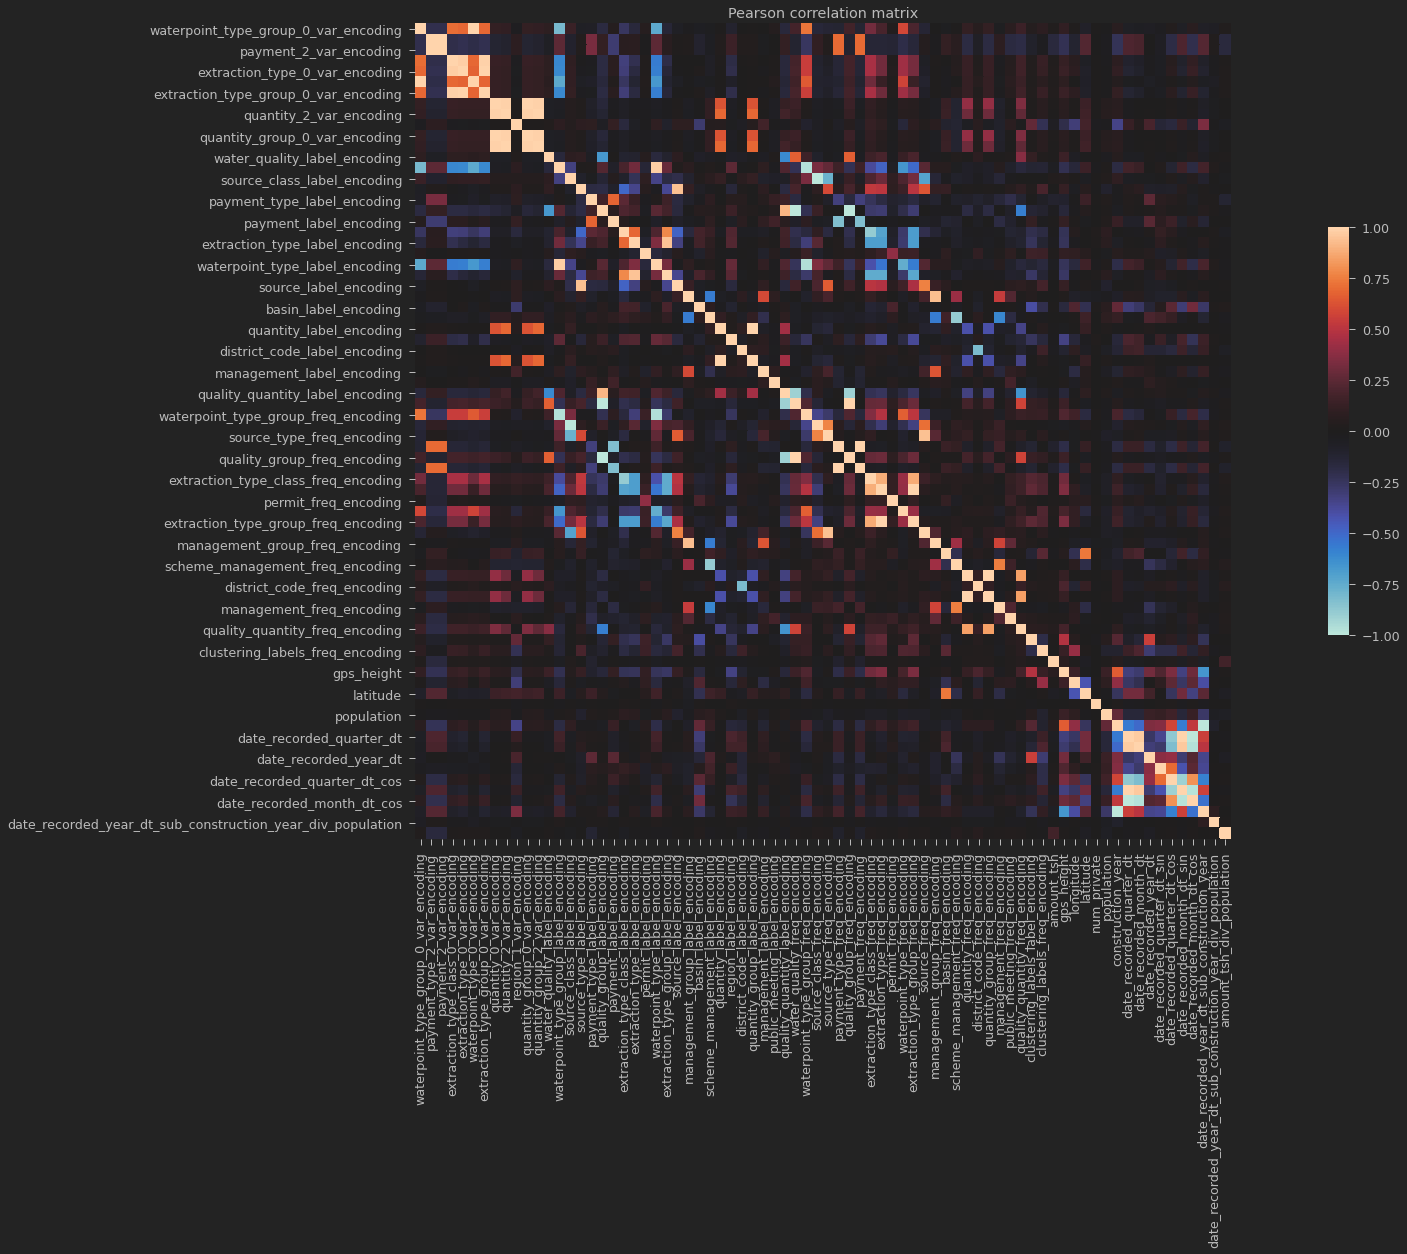

In [317]:
f, axs = plt.subplots(1, 1, figsize=(35, 15))

sns.heatmap(pearson_corr, center=0, square=True, cbar_kws={"shrink": .5}, ax=axs)
axs.set_title('Pearson correlation matrix');

In [318]:
pearson_corr_columns = get_correlated_columns(pearson_corr, threshold=0.95)
len(pearson_corr_columns)

20

In [319]:
best_features = [col for col in best_features if col not in pearson_corr_columns]
len(best_features)

56

### 3. Remove high correlated features (Phik)

In [320]:
phik_corr = X_train[best_features].phik_matrix()

interval columns not set, guessing: ['waterpoint_type_group_0_var_encoding', 'payment_type_2_var_encoding', 'extraction_type_class_0_var_encoding', 'quantity_0_var_encoding', 'region_1_var_encoding', 'water_quality_label_encoding', 'waterpoint_type_group_label_encoding', 'source_class_label_encoding', 'source_type_label_encoding', 'payment_type_label_encoding', 'quality_group_label_encoding', 'payment_label_encoding', 'extraction_type_class_label_encoding', 'extraction_type_label_encoding', 'permit_label_encoding', 'extraction_type_group_label_encoding', 'source_label_encoding', 'management_group_label_encoding', 'basin_label_encoding', 'scheme_management_label_encoding', 'quantity_label_encoding', 'region_label_encoding', 'district_code_label_encoding', 'management_label_encoding', 'public_meeting_label_encoding', 'quality_quantity_label_encoding', 'source_type_freq_encoding', 'payment_type_freq_encoding', 'extraction_type_class_freq_encoding', 'extraction_type_freq_encoding', 'permit

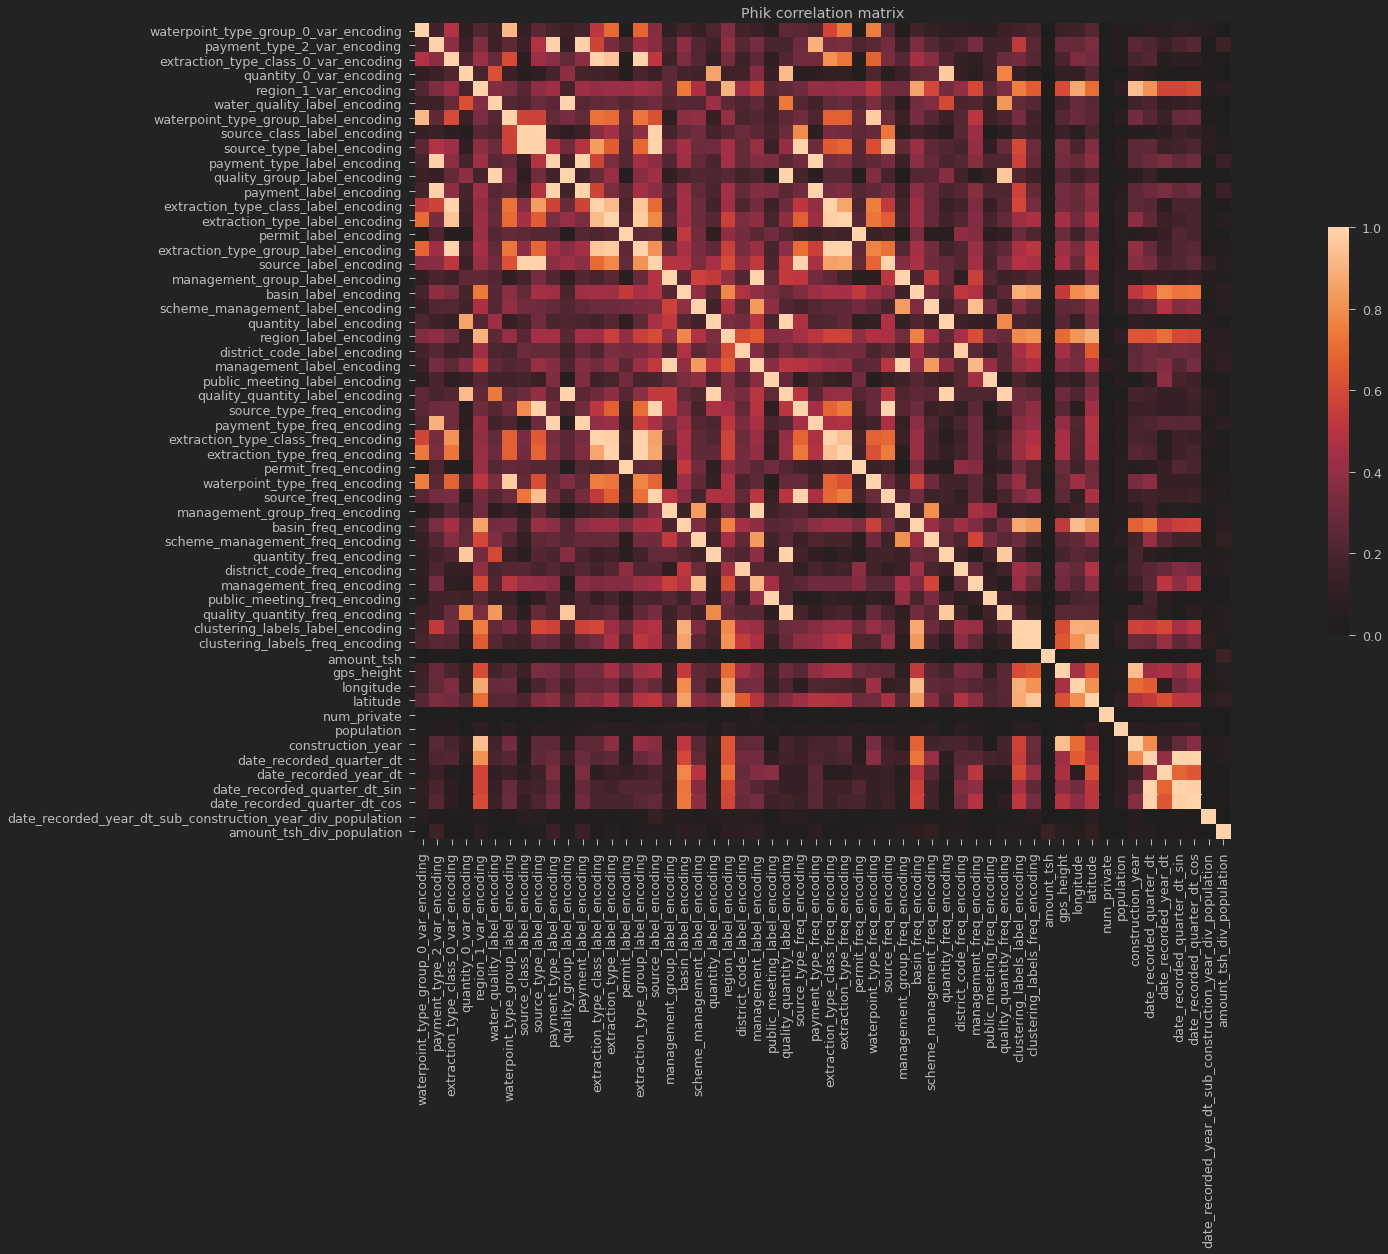

In [321]:
f, axs = plt.subplots(1, 1, figsize=(35, 15))

sns.heatmap(phik_corr, center=0, square=True, cbar_kws={"shrink": .5}, ax=axs)
axs.set_title('Phik correlation matrix');

In [322]:
phik_corr_columns = get_correlated_columns(phik_corr, threshold=0.95)
len(phik_corr_columns)

23

In [323]:
best_features = [col for col in best_features if col not in phik_corr_columns]
len(best_features)

33

### 4. Feature Selection - permutation + top-50

In [324]:
class PermutationImportanceFeatureSelectionTransformer():
    
    def __init__(self, model, n_repeats=10, scoring=roc_auc_score, random_state=42, n_jobs=1):
        super(PermutationImportanceFeatureSelectionTransformer, self).__init__()
        self.model = model
        self.n_repeats = n_repeats
        self.scoring = scoring
        self.seed = random_state
        self.n_jobs = n_jobs
        self.importances = {}
        self.features_in = []
        self.features_out = []

    def fit(self, X, y):
        self.features_in = X.columns.tolist()
        self.features_out = self.features_in.copy()

        y_pred = self.model.predict(X)
        baseline_score = self.scoring(y, y_pred)

        self.features = self.model.feature_name()

        importances = {}
        importances_parallel = Parallel(n_jobs=self.n_jobs)(delayed(self.loop_iter)(X, y, baseline_score) for _ in tqdm(range(self.n_repeats), position=0, leave=True))
            
        for importance in tqdm(importances_parallel):
            for feature in importance:
                if feature not in importances.keys():
                    importances[feature] = [importance[feature]]
                else:
                    importances[feature].append(importance[feature])

        self.features_out = []
        for k, v in tqdm(importances.items()):
            if np.mean(v) - np.std(v) > 0:
                self.features_out.append(k)

        self.importances = {f: (np.mean(v), np.std(v)) for f, v in importances.items() if f in self.features_out}

        return self
    
    def loop_iter(self, X, y, baseline_score):
        importances = dict()
        for feature in self.features:
            X_perm = self.permute_feature(X=X, feature=feature)
            y_perm = self.model.predict(X_perm)
            
            feature_score = self.scoring(y, y_perm)
            importances[feature] = baseline_score - feature_score
        return importances
                
    def permute_feature(self, X, feature):
        X_perm = X.copy()
        X_perm[feature] = np.random.permutation(X_perm[feature].values)
        return X_perm

    def __repr__(self):
        return "{0} by {1}".format(self.__class__.__name__, self.model) + (", Features={0}->{1}".format(len(self.features_in), len(self.features_out)) if len(self.features_in) > 0 and len(self.features_out) > 0 else "")


In [325]:
def get_best_perm_features(r, n_std=2, show_log=False) -> List[str]:
    best_features = list()
    importance = []
    for k, v in r.items():
        importance.append((k, v[0], v[1]))
    importance = sorted(importance, key=lambda x: x[1], reverse=True)

    for feature, mean, std in importance:
        if mean - n_std * std > 0:
            if show_log:
                print(f"{feature:<8}", f"{mean:.5f}", f" +/- {std:.5f}")
            best_features.append(feature)    
    return best_features

In [326]:
fit = lgb.Dataset(
    data=X_train[best_features], label=y_train,
)

val = lgb.Dataset(
    data=X_val[best_features], label=y_val,
    reference=fit,
)

model = lgb.train(
    params={'seed': SEED, 'num_class': NUM_CLASSES, 'objective': 'multiclass', 'is_unbalance': True, 'max_depth': -1, 'feature_fraction': 0.5,  'learning_rate': 0.01,  'zero_as_missing': False, 'boosting_type': 'gbdt', 'metric': [METRIC]},
    train_set=fit,
    num_boost_round=5000,
    valid_sets=(fit, val),
    valid_names=('train', 'val'),
    early_stopping_rounds=20,
    verbose_eval=25,
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 41580, number of used features: 33
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.621700
[LightGBM] [Info] Start training from score -0.956469
Training until validation scores don't improve for 20 rounds
[25]	train's auc_mu: 0.857071	val's auc_mu: 0.818968
[50]	train's auc_mu: 0.863565	val's auc_mu: 0.829993
[75]	train's auc_mu: 0.868558	val's auc_mu: 0.837492
[100]	train's auc_mu: 0.873351	val's auc_mu: 0.840647
[125]	train's auc_mu: 0.877369	val's auc_mu: 0.842297
[150]	train's auc_mu: 0.881048	val's auc_mu: 0.843742
[175]	train's auc_mu: 0.884755	val's auc_mu: 0.847583
[200]	train's auc_mu: 0.888073	val's auc_mu: 0

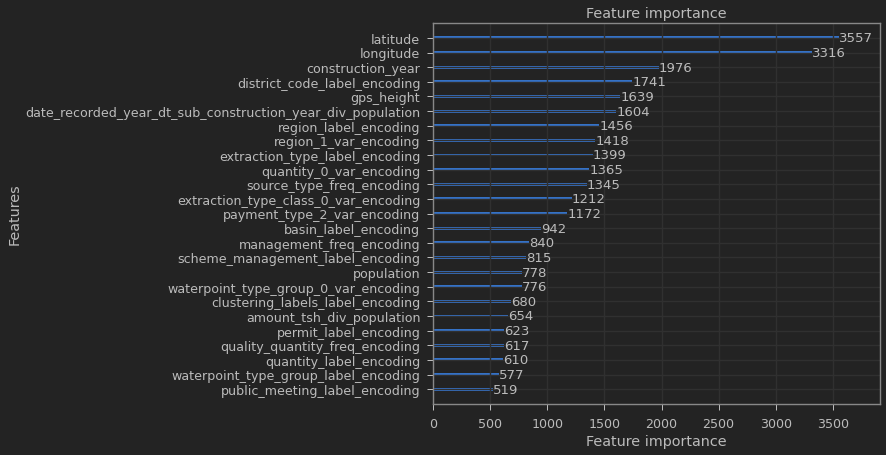

In [328]:
lgb.plot_importance(model, max_num_features=25);

In [329]:
best_10_features_baseline = list(map(lambda x: x[0], [(k, v) for k, v in sorted(zip(model.feature_name(), model.feature_importance()), key=lambda x: x[1], reverse=True) if v > 0][:10]))

In [330]:
VUSMetric = partial(roc_auc_score, multi_class='ovo', average='macro')
r = PermutationImportanceFeatureSelectionTransformer(model, n_repeats=4, random_state=SEED, n_jobs=4, scoring=VUSMetric)
r.fit(X_val[best_features], y_val)

100%|██████████| 33/33 [00:00<00:00, 8922.33it/s]


PermutationImportanceFeatureSelectionTransformer by <lightgbm.basic.Booster object at 0x7f821b77e240>, Features=33->28

In [331]:
filtered_features = get_best_perm_features(r.importances, show_log=True)
len(filtered_features)

quantity_label_encoding 0.05536  +/- 0.00110
extraction_type_label_encoding 0.02527  +/- 0.00111
waterpoint_type_group_label_encoding 0.02013  +/- 0.00068
construction_year 0.01890  +/- 0.00158
longitude 0.01754  +/- 0.00061
district_code_label_encoding 0.01708  +/- 0.00089
latitude 0.01374  +/- 0.00054
source_type_freq_encoding 0.01200  +/- 0.00131
amount_tsh_div_population 0.00842  +/- 0.00024
quality_quantity_freq_encoding 0.00834  +/- 0.00027
region_label_encoding 0.00748  +/- 0.00057
management_freq_encoding 0.00592  +/- 0.00094
payment_type_2_var_encoding 0.00432  +/- 0.00037
date_recorded_year_dt_sub_construction_year_div_population 0.00380  +/- 0.00060
gps_height 0.00380  +/- 0.00032
basin_label_encoding 0.00332  +/- 0.00038
clustering_labels_label_encoding 0.00327  +/- 0.00028
water_quality_label_encoding 0.00280  +/- 0.00026
population 0.00249  +/- 0.00014
source_class_label_encoding 0.00225  +/- 0.00017
scheme_management_label_encoding 0.00214  +/- 0.00023
permit_label_encod

27

In [332]:
best_features = list(set(filtered_features + best_10_features_baseline))
len(best_features)

29

In [333]:
pd.concat([X_train[best_features].reset_index(drop=True), pd.DataFrame(y_train, columns=[TARGET])], axis=1).corr().style.background_gradient(cmap='coolwarm').set_precision(3)

In [334]:
print('[', end='')
for feature in sorted(best_features):
    print(f"'{feature}'", end=',\n')
print(']')

['amount_tsh',
'amount_tsh_div_population',
'basin_label_encoding',
'clustering_labels_label_encoding',
'construction_year',
'date_recorded_quarter_dt',
'date_recorded_year_dt',
'date_recorded_year_dt_sub_construction_year_div_population',
'district_code_label_encoding',
'extraction_type_label_encoding',
'gps_height',
'latitude',
'longitude',
'management_freq_encoding',
'payment_type_2_var_encoding',
'payment_type_freq_encoding',
'permit_label_encoding',
'population',
'public_meeting_label_encoding',
'quality_quantity_freq_encoding',
'quantity_0_var_encoding',
'quantity_label_encoding',
'region_1_var_encoding',
'region_label_encoding',
'scheme_management_label_encoding',
'source_class_label_encoding',
'source_type_freq_encoding',
'water_quality_label_encoding',
'waterpoint_type_group_label_encoding',
]


## Dimensionality Reduction & Anomaly Detection

In [335]:
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

In [336]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [337]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [338]:
__colors = ['green', 'red', 'blue']
scaler = StandardScaler()
scaler.fit(X_train[best_features]);

In [339]:
pca = PCA(n_components=2)
X_train_pca_embedded = pca.fit_transform(scaler.transform(X_train[best_features]))
X_val_pca_embedded = pca.transform(scaler.transform(X_val[best_features]))

In [340]:
draw_vectors(X_train_pca_embedded[:, 0], X_train_pca_embedded[:, 1], color=[__colors[i] for i in y_train], target=y_train);

In [341]:
draw_vectors(X_val_pca_embedded[:, 0], X_val_pca_embedded[:, 1], color=[__colors[i] for i in y_val], target=y_val);

In [342]:
# isomap = Isomap(n_components=2, n_jobs=2)
# X_train_isomap_embedded = isomap.fit_transform(scaler.transform(X_train[best_features]))
# X_val_isomap_embedded = isomap.transform(scaler.transform(X_val[best_features]))

In [343]:
# draw_vectors(X_train_isomap_embedded[:, 0], X_train_isomap_embedded[:, 1], color=[__colors[i] for i in y_train], target=y_train);

In [344]:
# draw_vectors(X_val_isomap_embedded[:, 0], X_val_isomap_embedded[:, 1], color=[__colors[i] for i in y_val], target=y_val);

In [345]:
del X_train_pca_embedded, X_val_pca_embedded#, X_train_isomap_embedded, X_val_isomap_embedded

## Hyperparameters tuning

In [346]:
import optuna
from optuna.samplers import TPESampler

In [347]:
def optuna_objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': NUM_CLASSES,
        'zero_as_missing': False,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'num_threads': 10,
        'seed': SEED,
        'metric': METRIC,
        'max_depth': -1,  # {'default': -1, 'options': TunerNumberAxis(low=1, high=9, distribution='int')},
        'learning_rate': trial.suggest_loguniform('learning_rate', low=1e-5, high=0.2),
        'num_leaves': trial.suggest_categorical('num_leaves', [8, 16, 32, 64, 128, 256, 512]),#('num_leaves', [2, 4, 8, 16, 32, 64, 128, 256, 512]),
        'max_bin': trial.suggest_int('max_bin', low=8, high=255),
        'min_child_samples': trial.suggest_int('min_child_samples', low=0, high=20),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', low=0.01, high=1),
        'bagging_freq': trial.suggest_int('bagging_freq', low=0, high=32),
        'feature_fraction': trial.suggest_uniform('feature_fraction', low=0.01, high=1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', low=1e-8, high=12.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', low=1e-8, high=12.0),
#         'num_iterations': trial.suggest_int('num_iterations', low=100, high=10000, step=100),
    }
    
#     cv_split = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
#     folds = cv_split.split(X=X_train[best_features], y=y_train) 

#     dtrain = lgb.Dataset(
#         data=X_train[best_features], label=y_train,
#     )

#     lgbcv = lgb.cv(
#         params=params,
#         train_set=dtrain,
#         folds=folds,
#         seed=SEED,
#         metrics={METRIC},
#         verbose_eval=False,                   
#         early_stopping_rounds=25,                   
#         num_boost_round=5000,
#     )
#     metric_result = max(lgbcv[METRIC+'-mean'])

    fit = lgb.Dataset(
        X_train[best_features], y_train,
    )

    val = lgb.Dataset(
        X_val[best_features], y_val,
        reference=fit,
    )

    model = lgb.train(
        params=params,
        train_set=fit,
        num_boost_round=5000,
        valid_sets=(fit, val),
        valid_names=('train', 'val'),
        early_stopping_rounds=25,
        verbose_eval=False,
    )
    
    metric_result = VUSMetric(y_val, model.predict(X_val[best_features]))
    return metric_result

In [348]:
# Suppress information only outputs
# optuna.logging.set_verbosity(optuna.logging.WARNING) 
TPE_sampler = TPESampler(seed=SEED, n_startup_trials=100)
TPE_study = optuna.create_study(direction='maximize', sampler=TPE_sampler, study_name='TPE_study')
TPE_study.optimize(optuna_objective, n_trials=500, n_jobs=4, show_progress_bar=True)

[I 2021-11-22 23:54:56,807] A new study created in memory with name: TPE_study
[I 2021-11-22 23:54:58,264] Trial 2 finished with value: 0.7687802137972809 and parameters: {'learning_rate': 0.00036255926888560967, 'num_leaves': 16, 'max_bin': 221, 'min_child_samples': 2, 'bagging_fraction': 0.5347144139152817, 'bagging_freq': 25, 'feature_fraction': 0.5497609170768, 'lambda_l1': 2.395580677485259e-07, 'lambda_l2': 0.015948664661639574}. Best is trial 2 with value: 0.7687802137972809.
[I 2021-11-22 23:55:01,075] Trial 0 finished with value: 0.7847655838241314 and parameters: {'learning_rate': 0.0004052393155750672, 'num_leaves': 128, 'max_bin': 249, 'min_child_samples': 5, 'bagging_fraction': 0.05381022650238106, 'bagging_freq': 18, 'feature_fraction': 0.5319200763870258, 'lambda_l1': 0.002541360100964498, 'lambda_l2': 10.668240219226975}. Best is trial 0 with value: 0.7847655838241314.
[I 2021-11-22 23:55:01,927] Trial 5 finished with value: 0.7485369515219729 and parameters: {'learning

[I 2021-11-22 23:55:40,824] Trial 15 finished with value: 0.7932849918690038 and parameters: {'learning_rate': 1.6948838341319553e-05, 'num_leaves': 512, 'max_bin': 115, 'min_child_samples': 4, 'bagging_fraction': 0.6465740529854619, 'bagging_freq': 4, 'feature_fraction': 0.8068455989398117, 'lambda_l1': 0.3396611424707762, 'lambda_l2': 5.708847777542353e-05}. Best is trial 3 with value: 0.85571149382387.
[I 2021-11-22 23:55:41,561] Trial 24 finished with value: 0.7305944906285693 and parameters: {'learning_rate': 1.653968376739811e-05, 'num_leaves': 32, 'max_bin': 114, 'min_child_samples': 19, 'bagging_fraction': 0.6738257747774894, 'bagging_freq': 11, 'feature_fraction': 0.8619808446855698, 'lambda_l1': 0.0006359608256381064, 'lambda_l2': 0.006107290638490951}. Best is trial 3 with value: 0.85571149382387.
[I 2021-11-22 23:55:44,090] Trial 22 finished with value: 0.8016464199020813 and parameters: {'learning_rate': 0.024675013914136634, 'num_leaves': 8, 'max_bin': 183, 'min_child_sam

[I 2021-11-22 23:56:45,345] Trial 43 finished with value: 0.6688706437846577 and parameters: {'learning_rate': 0.008782363347806554, 'num_leaves': 512, 'max_bin': 192, 'min_child_samples': 1, 'bagging_fraction': 0.021128050651171786, 'bagging_freq': 29, 'feature_fraction': 0.8928848668775355, 'lambda_l1': 6.610855231960125e-07, 'lambda_l2': 2.019819432552308e-05}. Best is trial 28 with value: 0.859664171941041.
[I 2021-11-22 23:56:50,828] Trial 26 finished with value: 0.8445744268587371 and parameters: {'learning_rate': 0.006675097809485321, 'num_leaves': 512, 'max_bin': 242, 'min_child_samples': 12, 'bagging_fraction': 0.4292808818486824, 'bagging_freq': 11, 'feature_fraction': 0.6790922238177981, 'lambda_l1': 2.2524927876516974, 'lambda_l2': 0.0744342136435212}. Best is trial 28 with value: 0.859664171941041.
[I 2021-11-22 23:56:57,592] Trial 45 finished with value: 0.7714901030562921 and parameters: {'learning_rate': 1.4131498081402192e-05, 'num_leaves': 64, 'max_bin': 50, 'min_chil

[I 2021-11-22 23:57:46,329] Trial 62 finished with value: 0.8122391589937688 and parameters: {'learning_rate': 0.0016282408638952466, 'num_leaves': 64, 'max_bin': 8, 'min_child_samples': 2, 'bagging_fraction': 0.44211545594731894, 'bagging_freq': 29, 'feature_fraction': 0.2884145081628586, 'lambda_l1': 7.439370713020144e-08, 'lambda_l2': 1.3567507257304927}. Best is trial 40 with value: 0.866223173205908.
[I 2021-11-22 23:57:48,422] Trial 64 finished with value: 0.7824243846850704 and parameters: {'learning_rate': 0.12221185288026855, 'num_leaves': 128, 'max_bin': 23, 'min_child_samples': 1, 'bagging_fraction': 0.1640223307354094, 'bagging_freq': 2, 'feature_fraction': 0.8277077135128003, 'lambda_l1': 0.006305359109333513, 'lambda_l2': 3.451327513996073e-08}. Best is trial 40 with value: 0.866223173205908.
[I 2021-11-22 23:57:49,111] Trial 55 finished with value: 0.8458521138640158 and parameters: {'learning_rate': 0.01338600767274857, 'num_leaves': 32, 'max_bin': 76, 'min_child_sample

[I 2021-11-22 23:58:58,313] Trial 69 finished with value: 0.8678298890653192 and parameters: {'learning_rate': 0.010108159144945767, 'num_leaves': 64, 'max_bin': 217, 'min_child_samples': 2, 'bagging_fraction': 0.6672414780818189, 'bagging_freq': 3, 'feature_fraction': 0.3009051156369987, 'lambda_l1': 0.6712396425427888, 'lambda_l2': 8.571018489996602}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-22 23:58:58,564] Trial 83 finished with value: 0.7409247217476365 and parameters: {'learning_rate': 0.007569004812020706, 'num_leaves': 32, 'max_bin': 65, 'min_child_samples': 18, 'bagging_fraction': 0.6959614629389008, 'bagging_freq': 2, 'feature_fraction': 0.8150919830704471, 'lambda_l1': 5.9452754279595243e-08, 'lambda_l2': 6.010911418865791}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-22 23:59:00,442] Trial 85 finished with value: 0.7578082705658321 and parameters: {'learning_rate': 0.0003661680449376398, 'num_leaves': 16, 'max_bin': 23, 'min_child_samples'

[I 2021-11-23 00:00:24,128] Trial 98 finished with value: 0.869418331743001 and parameters: {'learning_rate': 0.024202981996902857, 'num_leaves': 512, 'max_bin': 140, 'min_child_samples': 10, 'bagging_fraction': 0.533874097550821, 'bagging_freq': 12, 'feature_fraction': 0.09415017608821237, 'lambda_l1': 1.0500087130160835e-05, 'lambda_l2': 9.369590987770105e-08}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:00:26,342] Trial 103 finished with value: 0.8671503863076439 and parameters: {'learning_rate': 0.1907107282471791, 'num_leaves': 64, 'max_bin': 142, 'min_child_samples': 12, 'bagging_fraction': 0.8101801502335211, 'bagging_freq': 0, 'feature_fraction': 0.2457284373554388, 'lambda_l1': 1.7558000595152088e-05, 'lambda_l2': 7.882146221822334e-06}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:00:29,723] Trial 101 finished with value: 0.8391752293642517 and parameters: {'learning_rate': 0.052010161317434564, 'num_leaves': 128, 'max_bin': 237, 'mi

[I 2021-11-23 00:01:34,542] Trial 122 finished with value: 0.8696155146549968 and parameters: {'learning_rate': 0.09189997570649701, 'num_leaves': 64, 'max_bin': 170, 'min_child_samples': 15, 'bagging_fraction': 0.999714359133412, 'bagging_freq': 22, 'feature_fraction': 0.10221615155980973, 'lambda_l1': 1.0646532508517878e-05, 'lambda_l2': 8.733076036140685e-08}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:01:41,107] Trial 123 finished with value: 0.8690737385450112 and parameters: {'learning_rate': 0.09075584611318203, 'num_leaves': 64, 'max_bin': 170, 'min_child_samples': 15, 'bagging_fraction': 0.9992079376739921, 'bagging_freq': 23, 'feature_fraction': 0.11078184328237065, 'lambda_l1': 1.0433135174557198e-05, 'lambda_l2': 7.939203732911181e-08}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:01:45,259] Trial 124 finished with value: 0.8690926625368869 and parameters: {'learning_rate': 0.09684504421284934, 'num_leaves': 64, 'max_bin': 170, 'm

[I 2021-11-23 00:03:01,853] Trial 141 finished with value: 0.8694693839121234 and parameters: {'learning_rate': 0.07299312179635066, 'num_leaves': 64, 'max_bin': 156, 'min_child_samples': 16, 'bagging_fraction': 0.9309863694649482, 'bagging_freq': 23, 'feature_fraction': 0.14207973008296157, 'lambda_l1': 7.52137882717251e-06, 'lambda_l2': 6.09692133152754e-08}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:03:05,709] Trial 142 finished with value: 0.8721703407630134 and parameters: {'learning_rate': 0.042204382935843526, 'num_leaves': 64, 'max_bin': 155, 'min_child_samples': 16, 'bagging_fraction': 0.9255347532511811, 'bagging_freq': 21, 'feature_fraction': 0.18361210675739986, 'lambda_l1': 7.217349981423901e-06, 'lambda_l2': 8.327622101784738e-07}. Best is trial 77 with value: 0.8786686791528573.
[I 2021-11-23 00:03:09,341] Trial 143 finished with value: 0.8733773558343448 and parameters: {'learning_rate': 0.03894924377213186, 'num_leaves': 64, 'max_bin': 157, 'min

[I 2021-11-23 00:08:06,192] Trial 161 finished with value: 0.8749956437076051 and parameters: {'learning_rate': 0.0038231252173698497, 'num_leaves': 256, 'max_bin': 124, 'min_child_samples': 17, 'bagging_fraction': 0.8413132390932128, 'bagging_freq': 18, 'feature_fraction': 0.21408374404120245, 'lambda_l1': 0.00024159938623548742, 'lambda_l2': 3.2636702703300148e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:08:08,835] Trial 160 finished with value: 0.8753375806642515 and parameters: {'learning_rate': 0.0036614799108315647, 'num_leaves': 256, 'max_bin': 122, 'min_child_samples': 17, 'bagging_fraction': 0.8749190799361528, 'bagging_freq': 19, 'feature_fraction': 0.21603181188430584, 'lambda_l1': 0.0005023490904861669, 'lambda_l2': 3.2380550581352375e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:08:38,589] Trial 162 finished with value: 0.874503750640575 and parameters: {'learning_rate': 0.0031757284379262778, 'num_leaves': 256, 'max_b

[I 2021-11-23 00:17:06,343] Trial 182 finished with value: 0.8481814962902098 and parameters: {'learning_rate': 0.001108519112371028, 'num_leaves': 256, 'max_bin': 98, 'min_child_samples': 17, 'bagging_fraction': 0.8219838337338773, 'bagging_freq': 19, 'feature_fraction': 0.2489308435901117, 'lambda_l1': 0.0007767780657616517, 'lambda_l2': 1.3243100078870679e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:17:12,156] Trial 183 finished with value: 0.8432515612536768 and parameters: {'learning_rate': 0.0023238914208552498, 'num_leaves': 256, 'max_bin': 94, 'min_child_samples': 17, 'bagging_fraction': 0.8634816802638141, 'bagging_freq': 15, 'feature_fraction': 0.24205613996102032, 'lambda_l1': 0.0005353458183705803, 'lambda_l2': 3.976201352535077e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:17:17,978] Trial 179 finished with value: 0.8796443718113207 and parameters: {'learning_rate': 0.0029287937482752684, 'num_leaves': 256, 'max_bin': 

[I 2021-11-23 00:26:31,667] Trial 198 finished with value: 0.8793059220061329 and parameters: {'learning_rate': 0.0026405676366683495, 'num_leaves': 256, 'max_bin': 100, 'min_child_samples': 20, 'bagging_fraction': 0.8162404186432383, 'bagging_freq': 20, 'feature_fraction': 0.3183714302006243, 'lambda_l1': 0.004012839916358912, 'lambda_l2': 9.801393629759033e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:26:35,481] Trial 197 finished with value: 0.8792317151749568 and parameters: {'learning_rate': 0.002336808909443831, 'num_leaves': 256, 'max_bin': 102, 'min_child_samples': 20, 'bagging_fraction': 0.8234712839558425, 'bagging_freq': 20, 'feature_fraction': 0.30775902215701845, 'lambda_l1': 0.004176408257027465, 'lambda_l2': 9.81195100457177e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:27:06,935] Trial 201 finished with value: 0.8790958922169064 and parameters: {'learning_rate': 0.0027801873310157313, 'num_leaves': 256, 'max_bin': 86

[I 2021-11-23 00:41:08,855] Trial 222 finished with value: 0.8497577709636905 and parameters: {'learning_rate': 0.0022666962960780396, 'num_leaves': 256, 'max_bin': 90, 'min_child_samples': 20, 'bagging_fraction': 0.8263659997092195, 'bagging_freq': 19, 'feature_fraction': 0.25129098782731174, 'lambda_l1': 0.003545858249487784, 'lambda_l2': 2.3644754252171798e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:41:28,919] Trial 218 finished with value: 0.8786497486622088 and parameters: {'learning_rate': 0.002229612158060557, 'num_leaves': 256, 'max_bin': 93, 'min_child_samples': 19, 'bagging_fraction': 0.9025709050008752, 'bagging_freq': 19, 'feature_fraction': 0.32027266312182945, 'lambda_l1': 0.002516882223731418, 'lambda_l2': 2.3362530011763307e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:43:06,568] Trial 224 finished with value: 0.8757802281588853 and parameters: {'learning_rate': 0.0032048072146792436, 'num_leaves': 256, 'max_bin': 

[I 2021-11-23 00:53:27,419] Trial 237 finished with value: 0.8800751084541619 and parameters: {'learning_rate': 0.0023733017015978844, 'num_leaves': 256, 'max_bin': 101, 'min_child_samples': 18, 'bagging_fraction': 0.8532933826495417, 'bagging_freq': 18, 'feature_fraction': 0.24233969284342985, 'lambda_l1': 0.0007557927751775855, 'lambda_l2': 4.540698610661696e-06}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:54:02,745] Trial 238 finished with value: 0.8807803476591953 and parameters: {'learning_rate': 0.0023747489043294536, 'num_leaves': 256, 'max_bin': 100, 'min_child_samples': 18, 'bagging_fraction': 0.8533448662124938, 'bagging_freq': 18, 'feature_fraction': 0.2468143880323422, 'lambda_l1': 0.0007243456901250551, 'lambda_l2': 8.40736809064952e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 00:55:29,098] Trial 239 finished with value: 0.8797218927524622 and parameters: {'learning_rate': 0.00241967076257273, 'num_leaves': 256, 'max_bin': 9

[I 2021-11-23 01:03:35,591] Trial 260 finished with value: 0.874523417016217 and parameters: {'learning_rate': 0.004594466633673151, 'num_leaves': 256, 'max_bin': 115, 'min_child_samples': 17, 'bagging_fraction': 0.8758544896149628, 'bagging_freq': 17, 'feature_fraction': 0.19894619901965604, 'lambda_l1': 0.0010516582858647184, 'lambda_l2': 0.00015269036490917284}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:03:42,560] Trial 261 finished with value: 0.8719708106745309 and parameters: {'learning_rate': 0.004810455334443788, 'num_leaves': 256, 'max_bin': 115, 'min_child_samples': 17, 'bagging_fraction': 0.8046720967396452, 'bagging_freq': 16, 'feature_fraction': 0.26980520043813266, 'lambda_l1': 0.000902569267921037, 'lambda_l2': 3.809377428513526e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:03:47,207] Trial 262 finished with value: 0.875665308395606 and parameters: {'learning_rate': 0.004443051285419891, 'num_leaves': 256, 'max_bin': 11

[I 2021-11-23 01:11:02,002] Trial 282 finished with value: 0.843177142217348 and parameters: {'learning_rate': 0.001714597124548641, 'num_leaves': 256, 'max_bin': 88, 'min_child_samples': 18, 'bagging_fraction': 0.8666423850382549, 'bagging_freq': 13, 'feature_fraction': 0.20611393117267468, 'lambda_l1': 0.00048221222230008506, 'lambda_l2': 0.001073641820808514}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:11:21,751] Trial 276 finished with value: 0.874960701157386 and parameters: {'learning_rate': 0.0032727064265860445, 'num_leaves': 256, 'max_bin': 110, 'min_child_samples': 17, 'bagging_fraction': 0.8136867911117319, 'bagging_freq': 18, 'feature_fraction': 0.21919417233032334, 'lambda_l1': 0.001420114197185202, 'lambda_l2': 0.0006890084396006331}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:12:27,753] Trial 277 finished with value: 0.8750290082220143 and parameters: {'learning_rate': 0.0027557048296108504, 'num_leaves': 256, 'max_bin': 11

[I 2021-11-23 01:18:43,605] Trial 299 finished with value: 0.8810779763696859 and parameters: {'learning_rate': 0.008917205982299154, 'num_leaves': 256, 'max_bin': 137, 'min_child_samples': 19, 'bagging_fraction': 0.9236388631398675, 'bagging_freq': 16, 'feature_fraction': 0.1772053664562886, 'lambda_l1': 0.002185942288297459, 'lambda_l2': 3.0721051578989675e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:18:50,557] Trial 300 finished with value: 0.8801802881268768 and parameters: {'learning_rate': 0.006923168989594142, 'num_leaves': 256, 'max_bin': 132, 'min_child_samples': 19, 'bagging_fraction': 0.8795849341184759, 'bagging_freq': 16, 'feature_fraction': 0.17971841248826276, 'lambda_l1': 0.002986920583291144, 'lambda_l2': 9.929206540673975e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:18:58,804] Trial 301 finished with value: 0.8802062449572693 and parameters: {'learning_rate': 0.008531072151772527, 'num_leaves': 256, 'max_bin': 13

[I 2021-11-23 01:23:37,822] Trial 316 finished with value: 0.8817689677143771 and parameters: {'learning_rate': 0.0061063810365995464, 'num_leaves': 256, 'max_bin': 146, 'min_child_samples': 19, 'bagging_fraction': 0.9439285683611888, 'bagging_freq': 15, 'feature_fraction': 0.1771041690444491, 'lambda_l1': 0.005961636333061159, 'lambda_l2': 6.191516002358436e-05}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:24:00,186] Trial 320 finished with value: 0.8726131572723891 and parameters: {'learning_rate': 0.010670669095879685, 'num_leaves': 512, 'max_bin': 142, 'min_child_samples': 19, 'bagging_fraction': 0.9423532585258975, 'bagging_freq': 13, 'feature_fraction': 0.11579823371537205, 'lambda_l1': 0.01672816237815601, 'lambda_l2': 0.00010856731355456498}. Best is trial 151 with value: 0.8822998365821384.
[I 2021-11-23 01:24:21,366] Trial 321 finished with value: 0.8813095763019309 and parameters: {'learning_rate': 0.011189094053388783, 'num_leaves': 256, 'max_bin': 14

[I 2021-11-23 01:28:43,921] Trial 339 finished with value: 0.8754291652301829 and parameters: {'learning_rate': 0.009531320097118864, 'num_leaves': 256, 'max_bin': 161, 'min_child_samples': 20, 'bagging_fraction': 0.9790851236409622, 'bagging_freq': 11, 'feature_fraction': 0.13926651191938763, 'lambda_l1': 0.020066124799228185, 'lambda_l2': 3.2160424789463726e-05}. Best is trial 323 with value: 0.8823076805546002.
[I 2021-11-23 01:28:48,815] Trial 340 finished with value: 0.8731963923363132 and parameters: {'learning_rate': 0.009667597686128085, 'num_leaves': 256, 'max_bin': 140, 'min_child_samples': 20, 'bagging_fraction': 0.9828677386173142, 'bagging_freq': 13, 'feature_fraction': 0.19641279629217212, 'lambda_l1': 0.008902978921045438, 'lambda_l2': 6.909091776202523e-05}. Best is trial 323 with value: 0.8823076805546002.
[I 2021-11-23 01:28:54,761] Trial 342 finished with value: 0.8742542884262985 and parameters: {'learning_rate': 0.009370075361951986, 'num_leaves': 256, 'max_bin': 1

[I 2021-11-23 01:34:11,275] Trial 359 finished with value: 0.847016639008585 and parameters: {'learning_rate': 0.005986507620412761, 'num_leaves': 256, 'max_bin': 154, 'min_child_samples': 20, 'bagging_fraction': 0.9635390083460472, 'bagging_freq': 11, 'feature_fraction': 0.08151534973028851, 'lambda_l1': 0.024528217844536716, 'lambda_l2': 0.00013498677535642988}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:34:39,527] Trial 360 finished with value: 0.8750241341422066 and parameters: {'learning_rate': 0.007415971144892634, 'num_leaves': 128, 'max_bin': 130, 'min_child_samples': 20, 'bagging_fraction': 0.9694273753373578, 'bagging_freq': 9, 'feature_fraction': 0.15065975363689368, 'lambda_l1': 0.028419317365185194, 'lambda_l2': 0.00011777246380650546}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:34:56,214] Trial 361 finished with value: 0.8748441859142216 and parameters: {'learning_rate': 0.0075866019056952325, 'num_leaves': 256, 'max_bin': 1

[I 2021-11-23 01:41:28,616] Trial 379 finished with value: 0.8812118616205953 and parameters: {'learning_rate': 0.007971652106891379, 'num_leaves': 256, 'max_bin': 137, 'min_child_samples': 20, 'bagging_fraction': 0.91145843005195, 'bagging_freq': 11, 'feature_fraction': 0.18823814784987386, 'lambda_l1': 0.011635388307855547, 'lambda_l2': 0.00010150453705717577}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:41:42,266] Trial 381 finished with value: 0.8744343624008785 and parameters: {'learning_rate': 0.00874322797417182, 'num_leaves': 256, 'max_bin': 123, 'min_child_samples': 20, 'bagging_fraction': 0.9126157684287582, 'bagging_freq': 11, 'feature_fraction': 0.14026291662508847, 'lambda_l1': 0.011486459957543911, 'lambda_l2': 4.769438707321594e-05}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:41:43,979] Trial 380 finished with value: 0.875265911868266 and parameters: {'learning_rate': 0.008555127383429378, 'num_leaves': 256, 'max_bin': 123, 

[I 2021-11-23 01:46:26,408] Trial 402 finished with value: 0.8583930878602288 and parameters: {'learning_rate': 0.025730784457764295, 'num_leaves': 16, 'max_bin': 161, 'min_child_samples': 20, 'bagging_fraction': 0.998598976373115, 'bagging_freq': 13, 'feature_fraction': 0.20438480205967352, 'lambda_l1': 2.6367315785673208e-05, 'lambda_l2': 0.0003201821049954138}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:46:32,765] Trial 401 finished with value: 0.8584236949047986 and parameters: {'learning_rate': 0.010652845376962745, 'num_leaves': 16, 'max_bin': 159, 'min_child_samples': 20, 'bagging_fraction': 0.9257331822773244, 'bagging_freq': 15, 'feature_fraction': 0.12266099291782787, 'lambda_l1': 1.4534468438612026e-05, 'lambda_l2': 0.00015417675136606416}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:46:36,864] Trial 399 finished with value: 0.8743525234292573 and parameters: {'learning_rate': 0.010626816466997846, 'num_leaves': 256, 'max_bin': 

[I 2021-11-23 01:49:15,186] Trial 418 finished with value: 0.8755614957040491 and parameters: {'learning_rate': 0.014082476439485275, 'num_leaves': 256, 'max_bin': 128, 'min_child_samples': 16, 'bagging_fraction': 0.923820450213245, 'bagging_freq': 12, 'feature_fraction': 0.21387138449207857, 'lambda_l1': 1.5043804121454715e-05, 'lambda_l2': 5.6232575998150956e-05}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:49:23,623] Trial 421 finished with value: 0.8726676086574185 and parameters: {'learning_rate': 0.013872748287013471, 'num_leaves': 256, 'max_bin': 127, 'min_child_samples': 19, 'bagging_fraction': 0.9982730095942469, 'bagging_freq': 14, 'feature_fraction': 0.13935190667218, 'lambda_l1': 8.52032320096124e-06, 'lambda_l2': 9.337403400345337e-07}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:49:43,395] Trial 420 finished with value: 0.8741996691614803 and parameters: {'learning_rate': 0.009012945107192223, 'num_leaves': 256, 'max_bin': 151

[I 2021-11-23 01:54:17,806] Trial 440 finished with value: 0.8746984084060951 and parameters: {'learning_rate': 0.011879783489719919, 'num_leaves': 256, 'max_bin': 173, 'min_child_samples': 19, 'bagging_fraction': 0.9995357195324956, 'bagging_freq': 15, 'feature_fraction': 0.13970941566819411, 'lambda_l1': 6.716511115649017e-05, 'lambda_l2': 0.012347374618841883}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:54:37,126] Trial 441 finished with value: 0.8816894374707598 and parameters: {'learning_rate': 0.010054118986994208, 'num_leaves': 256, 'max_bin': 174, 'min_child_samples': 17, 'bagging_fraction': 0.9328530118537658, 'bagging_freq': 15, 'feature_fraction': 0.1631772892419604, 'lambda_l1': 7.344264949218222e-05, 'lambda_l2': 3.415747214630801e-05}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 01:54:38,292] Trial 438 finished with value: 0.8738549393026883 and parameters: {'learning_rate': 0.007783532586183755, 'num_leaves': 256, 'max_bin': 16

[I 2021-11-23 01:59:53,041] Trial 460 finished with value: 0.8749885719075442 and parameters: {'learning_rate': 0.008661747270809799, 'num_leaves': 256, 'max_bin': 173, 'min_child_samples': 17, 'bagging_fraction': 0.9184407224401276, 'bagging_freq': 14, 'feature_fraction': 0.19297978100568763, 'lambda_l1': 2.8857810676534703e-05, 'lambda_l2': 0.0027023044228002796}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 02:00:10,968] Trial 459 finished with value: 0.875751655603424 and parameters: {'learning_rate': 0.007028807177114234, 'num_leaves': 256, 'max_bin': 180, 'min_child_samples': 16, 'bagging_fraction': 0.910540580276113, 'bagging_freq': 14, 'feature_fraction': 0.19409813164398168, 'lambda_l1': 3.100494644189128e-05, 'lambda_l2': 0.0026501593138500584}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 02:00:31,183] Trial 464 finished with value: 0.872944988388144 and parameters: {'learning_rate': 0.033884560576783525, 'num_leaves': 256, 'max_bin': 17

[I 2021-11-23 02:05:17,713] Trial 479 finished with value: 0.8803091467633787 and parameters: {'learning_rate': 0.010299306753379766, 'num_leaves': 512, 'max_bin': 143, 'min_child_samples': 16, 'bagging_fraction': 0.9252275792495086, 'bagging_freq': 21, 'feature_fraction': 0.18176662713197586, 'lambda_l1': 1.1394786408816855e-05, 'lambda_l2': 0.0009225685589180784}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 02:06:41,664] Trial 480 finished with value: 0.8814974862576582 and parameters: {'learning_rate': 0.004697871401815539, 'num_leaves': 512, 'max_bin': 170, 'min_child_samples': 16, 'bagging_fraction': 0.9200776545089916, 'bagging_freq': 17, 'feature_fraction': 0.1841797571902823, 'lambda_l1': 1.2599263638214979e-05, 'lambda_l2': 0.0072386678914900665}. Best is trial 350 with value: 0.8826272537250004.
[I 2021-11-23 02:07:14,311] Trial 481 finished with value: 0.882321813116136 and parameters: {'learning_rate': 0.004317298528128656, 'num_leaves': 256, 'max_bin': 

[I 2021-11-23 02:12:53,438] Trial 499 finished with value: 0.8741683186603799 and parameters: {'learning_rate': 0.011679515060029901, 'num_leaves': 256, 'max_bin': 189, 'min_child_samples': 17, 'bagging_fraction': 0.9074889882263538, 'bagging_freq': 21, 'feature_fraction': 0.1428080378628576, 'lambda_l1': 6.218223971702736e-06, 'lambda_l2': 0.010821080195708179}. Best is trial 350 with value: 0.8826272537250004.


In [349]:
TPE_study.best_value, TPE_study.best_params

(0.8826272537250004,
 {'learning_rate': 0.006079202240916264,
  'num_leaves': 256,
  'max_bin': 135,
  'min_child_samples': 20,
  'bagging_fraction': 0.9965092091880184,
  'bagging_freq': 14,
  'feature_fraction': 0.16833288864099755,
  'lambda_l1': 0.004336087014120275,
  'lambda_l2': 4.628987200016386e-05})

In [350]:
best_params = TPE_study.best_params.copy()
best_params['max_depth'] = -1
best_params['metric'] = METRIC
best_params['zero_as_missing'] = False
best_params['verbosity'] = -1
best_params['boosting_type'] = 'gbdt'
best_params['seed'] = SEED
best_params['num_class'] = NUM_CLASSES
best_params['is_unbalance'] = True
best_params['num_threads'] = 10
best_params['objective'] = 'multiclass'
best_params, TPE_study.best_value

({'learning_rate': 0.006079202240916264,
  'num_leaves': 256,
  'max_bin': 135,
  'min_child_samples': 20,
  'bagging_fraction': 0.9965092091880184,
  'bagging_freq': 14,
  'feature_fraction': 0.16833288864099755,
  'lambda_l1': 0.004336087014120275,
  'lambda_l2': 4.628987200016386e-05,
  'max_depth': -1,
  'metric': 'auc_mu',
  'zero_as_missing': False,
  'verbosity': -1,
  'boosting_type': 'gbdt',
  'seed': 42,
  'num_class': 3,
  'is_unbalance': True,
  'num_threads': 10,
  'objective': 'multiclass'},
 0.8826272537250004)

In [351]:
optuna.visualization.plot_optimization_history(TPE_study)

In [352]:
optuna.visualization.plot_slice(TPE_study)

In [353]:
optuna.visualization.plot_param_importances(TPE_study)

## Find best **_num_bust_rounds_**

In [354]:
fit = lgb.Dataset(
    X_train[best_features], y_train,
)

val = lgb.Dataset(
    X_val[best_features], y_val,
    reference=fit,
)

model = lgb.train(
    params=best_params,
    train_set=fit,
    num_boost_round=5000,
    valid_sets=(fit, val),
    valid_names=('train', 'val'),
    early_stopping_rounds=25,
    verbose_eval=False,
)

num_boost_round = num_boost_round = model.best_iteration
print('num_boost_round:', num_boost_round)

num_boost_round: 1544


## Cross-validate model

In [355]:
def plot_score_distr(y_pred, y_target, is_train=False):
    fig, ax = plt.subplots(1,1, figsize=(20, 8))

    sns.distplot(y_pred[y_target[y_target == 0].index], ax=ax, color='blue')
    sns.distplot(y_pred[y_target[y_target == 1].index], ax=ax, color='orange')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Train score distribution' if is_train else 'Val score distribution')
    ax.set_ylim(0, 20)
    plt.show()
    
def plot_feature_distr(data1, data2=None, data3=None,
                       feature=None,
                       label1='train', label2='test', label3='train+test',
                       color1='blue', color2='red', color3='green',
                       hist=True, kde=True,
                      ):
    fig, ax = plt.subplots(1,1, figsize=(20, 8))

    sns.distplot(data1, ax=ax, color=color1, label=label1, hist=hist, kde=kde)
    
    if data2 is not None:
        sns.distplot(data2, ax=ax, color=color2, label=label2, hist=hist, kde=kde)
        
    if data3 is not None:
        sns.distplot(data3, ax=ax, color=color3, label=label3, hist=hist, kde=kde)
        
    ax.set_xlabel('feature_value')
    ax.set_ylabel('Frequency')
    ax.set_title('' if feature is None else f'{feature} distribution')
    plt.legend()
    plt.show()

0it [00:00, ?it/s]

Train/Val shapes:
((27720, 29), (27720,)) ((13860, 29), (13860,))
Train/Val bad rates:
0.8411616161616161 0.8411976911976912
Train/Val bad`s count:
23317 11659

Train/Val VUS:
0.9804935613471795 0.8699262445126341


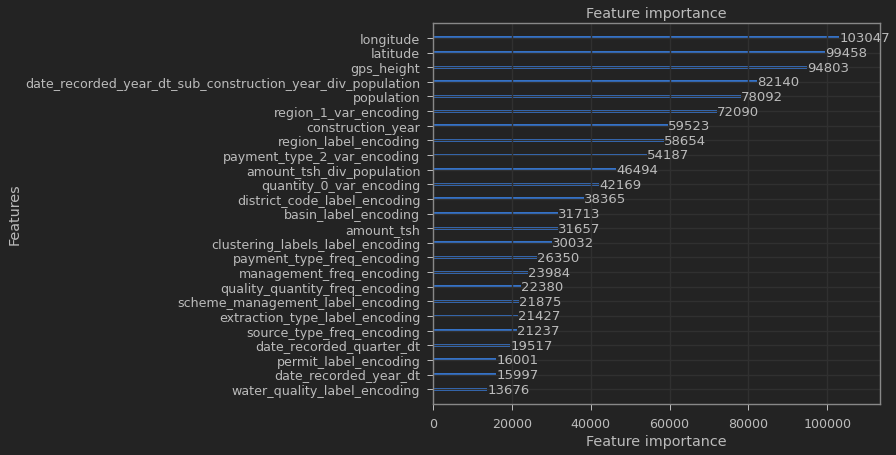

1it [01:52, 112.24s/it]

**************************************************
**************************************************

Train/Val shapes:
((27720, 29), (27720,)) ((13860, 29), (13860,))
Train/Val bad rates:
0.8411616161616161 0.8411976911976912
Train/Val bad`s count:
23317 11659

Train/Val VUS:
0.9803562219814349 0.8765483058377956


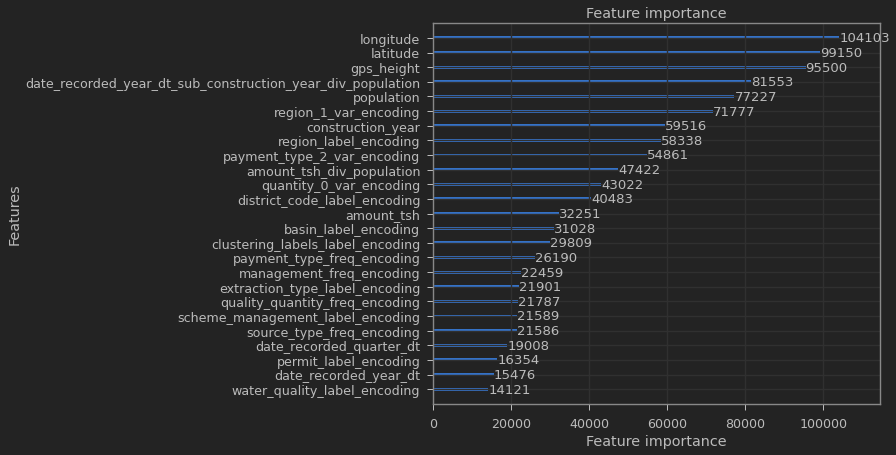

2it [03:36, 107.57s/it]

**************************************************
**************************************************

Train/Val shapes:
((27720, 29), (27720,)) ((13860, 29), (13860,))
Train/Val bad rates:
0.8411976911976912 0.8411255411255412
Train/Val bad`s count:
23318 11658

Train/Val VUS:
0.9801089864372865 0.8762689591089089


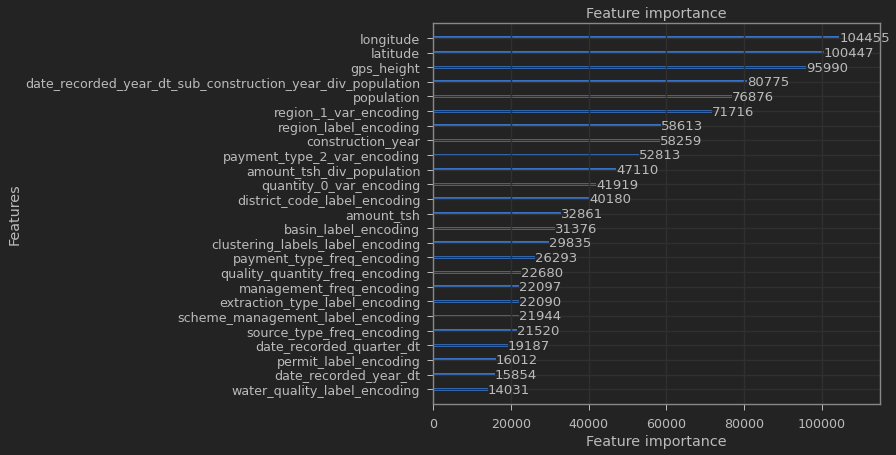

3it [05:21, 107.10s/it]

**************************************************
**************************************************

Average VUS Train: 0.980319589921967
Average VUS Val: 0.8742478364864462



In [356]:
cv_split = StratifiedKFold(n_splits=3, random_state=SEED, shuffle=True)
folds = cv_split.split(X=X_train, y=y_train) 

y_test_pred_history = list()
y_test_target_history = list()

y_train_pred_history = list()
y_train_target_history = list()

vus_train_avg = list()
vus_test_avg = list() 

for train_index, test_index in tqdm(folds, position=0, leave=True):
    X_train_fold = X_train.loc[train_index, best_features]
    y_train_fold = y_train[train_index]

    X_test_fold = X_train.loc[test_index, best_features]
    y_test_fold = y_train[test_index]
    

    print('Train/Val shapes:')
    print((X_train_fold.shape, y_train_fold.shape), (X_test_fold.shape, y_test_fold.shape))
    
    print('Train/Val bad rates:')
    print(y_train_fold.mean(), y_test_fold.mean())
    
    print('Train/Val bad`s count:')
    print(y_train_fold.sum(), y_test_fold.sum())
    print()
    
    train_fold = lgb.Dataset(
        X_train_fold,
        label=y_train_fold,
    )
    test_fold = lgb.Dataset(
        X_test_fold,
        label=y_test_fold,
        reference=train_fold,
    )
    
    model = lgb.train(
        params=best_params,
        train_set=train_fold,
        num_boost_round=num_boost_round,
        valid_sets=(train_fold, test_fold),
        valid_names=('train', 'val'),
        verbose_eval=False,
    )
    
    y_train_pred_fold = model.predict(X_train_fold)
    y_test_pred_fold = model.predict(X_test_fold)
    
    vus_train_avg.append(VUSMetric(y_train_fold, y_train_pred_fold))
    vus_test_avg.append(VUSMetric(y_test_fold, y_test_pred_fold))
    
    print('Train/Val VUS:')
    print(VUSMetric(y_train_fold, y_train_pred_fold), VUSMetric(y_test_fold, y_test_pred_fold))
    
    lgb.plot_importance(model, max_num_features=25);
    plt.show()
    print('*'*50)
    print('*'*50)
    print()
    
print('Average VUS Train:', np.mean(vus_train_avg))
print('Average VUS Val:', np.mean(vus_test_avg))
print()

## Train one model on train dataset

In [357]:
fit = lgb.Dataset(
    X_train[best_features], y_train,
)

val = lgb.Dataset(
    X_val[best_features], y_val,
    reference=fit,
)

model = lgb.train(
    params=best_params,
    train_set=fit,
    num_boost_round=num_boost_round,
    verbose_eval=False,
)

In [358]:
print(f'VUS (TRAIN): {VUSMetric(y_train, model.predict(X_train[best_features]))}')
print(f'VUS (VAL): {VUSMetric(y_val, model.predict(X_val[best_features]))}')
print(f'VUS (TEST): {VUSMetric(y_test, model.predict(X_test[best_features]))}')

VUS (TRAIN): 0.9704258276394909
VUS (VAL): 0.8826272537250004
VUS (TEST): 0.8806945341242782


In [359]:
print('*'*10 + 'TRAIN' + '*'*10)
print(classification_report(y_train, list(map(np.argmax, model.predict(X_train[best_features])))))
print()

print('*'*10 + 'VAL' + '*'*10)
print(classification_report(y_val, list(map(np.argmax, model.predict(X_val[best_features])))))
print()

print('*'*10 + 'TEST' + '*'*10)
print(classification_report(y_test, list(map(np.argmax, model.predict(X_test[best_features])))))
print()

**********TRAIN**********
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     22581
           1       0.88      0.55      0.67      3022
           2       0.93      0.84      0.88     15977

    accuracy                           0.88     41580
   macro avg       0.89      0.78      0.82     41580
weighted avg       0.88      0.88      0.88     41580


**********VAL**********
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      4839
           1       0.69      0.17      0.28       647
           2       0.83      0.76      0.79      3424

    accuracy                           0.80      8910
   macro avg       0.77      0.61      0.64      8910
weighted avg       0.79      0.80      0.78      8910


**********TEST**********
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      4839
           1       0.65      0.17      0.27       64

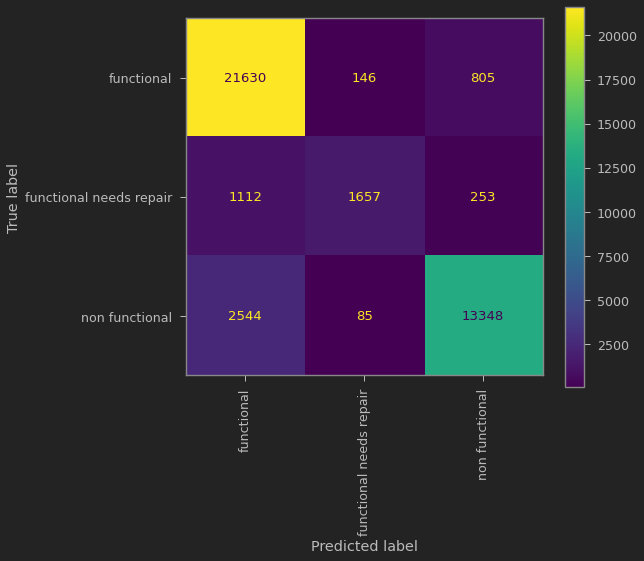

In [360]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train, list(map(np.argmax, model.predict(X_train[best_features]))),),
    display_labels=target_le.classes_
)
disp.plot(xticks_rotation='vertical')

## Train final model

In [369]:
# ce_mean_target_1.use_kflod_strategy = True
# ce_mean_target_2.use_kflod_strategy = True
ce_var_target_1.use_kflod_strategy = True
ce_var_target_2.use_kflod_strategy = True

y_train = target_le.transform(df_train[TARGET])
features_pipeline.fit(df_train, pd.Series(y_train, name=TARGET));
X_train = features_pipeline.transform(df_train).reset_index(drop=True)[best_features]
X_train.shape

dtrain = lgb.Dataset(
    X_train, label=y_train,
)

model_full = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=num_boost_round,
    valid_sets=(dtrain),
    valid_names=('train'),
    verbose_eval=False,
)

## Validate final model

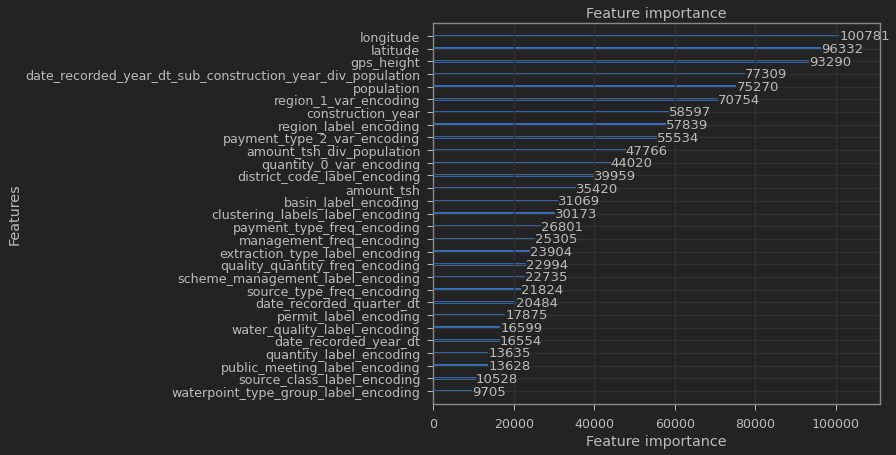

In [370]:
lgb.plot_importance(model_full, max_num_features=30);

In [371]:
explainer = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(X_train)[1]

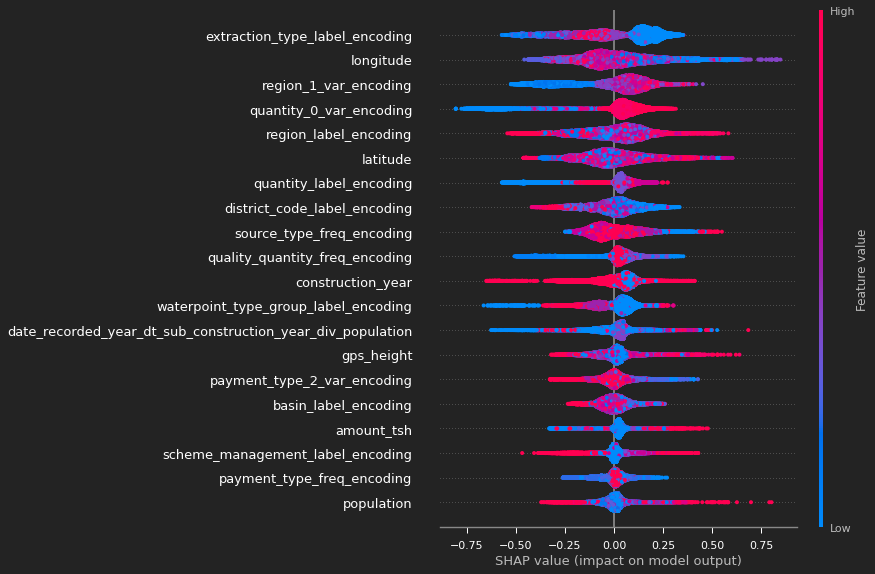

In [372]:
shap.summary_plot(shap_values, X_train, axis_color='white')

## Prediction

In [373]:
# ce_mean_target_1.use_kflod_strategy = False
# ce_mean_target_2.use_kflod_strategy = False
ce_var_target_1.use_kflod_strategy = False
ce_var_target_2.use_kflod_strategy = False

X_test = features_pipeline.transform(df_test).reset_index(drop=True)[best_features]
X_test.shape

(14850, 29)

In [374]:
y_test_pred_raw = model_full.predict(X_test)

## Save results!

In [375]:
submissions = pd.read_csv(PATH2DATA / 'Submission_format.csv')

In [376]:
submissions['status_group'] = target_le.inverse_transform(list(map(np.argmax, y_test_pred_raw)))

In [377]:
submissions.to_csv(PATH2OUTPUT / 'submission.csv', index=False)